## ImgFeat – Pipeline End-to-End


Esta notebook replica el flujo completo desde la imagen cruda hasta el vector de características.

1. Cargamos una muestra del repositorio (`Repo`).
2. Preprocesamos con `ImgPreproc` para obtener imagen alineada, máscara y metadatos.
3. Visualizamos los pasos clave con `matplotlib`.
4. Extraemos el descriptor con `ImgFeat` y listamos los valores 7D.


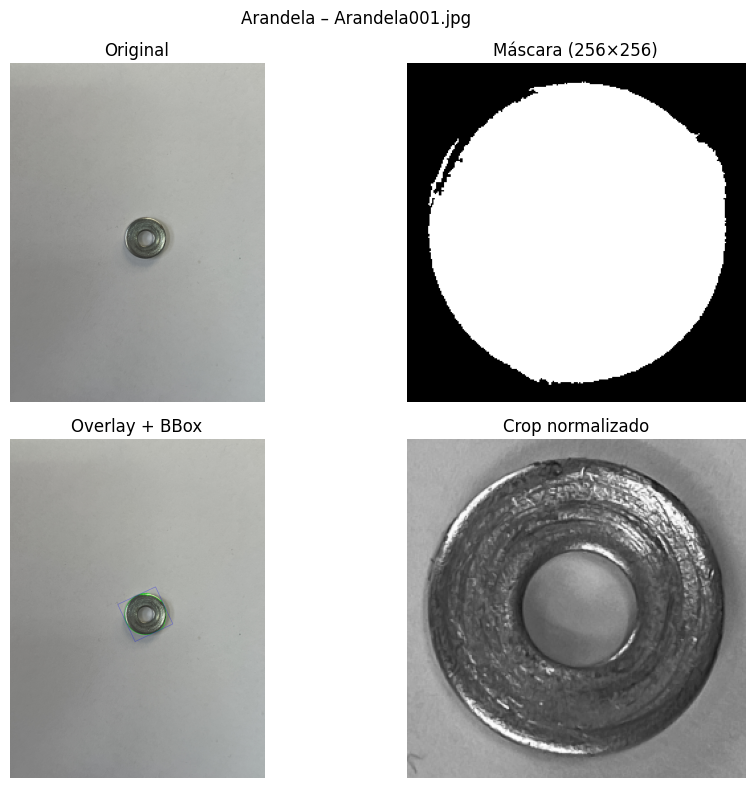

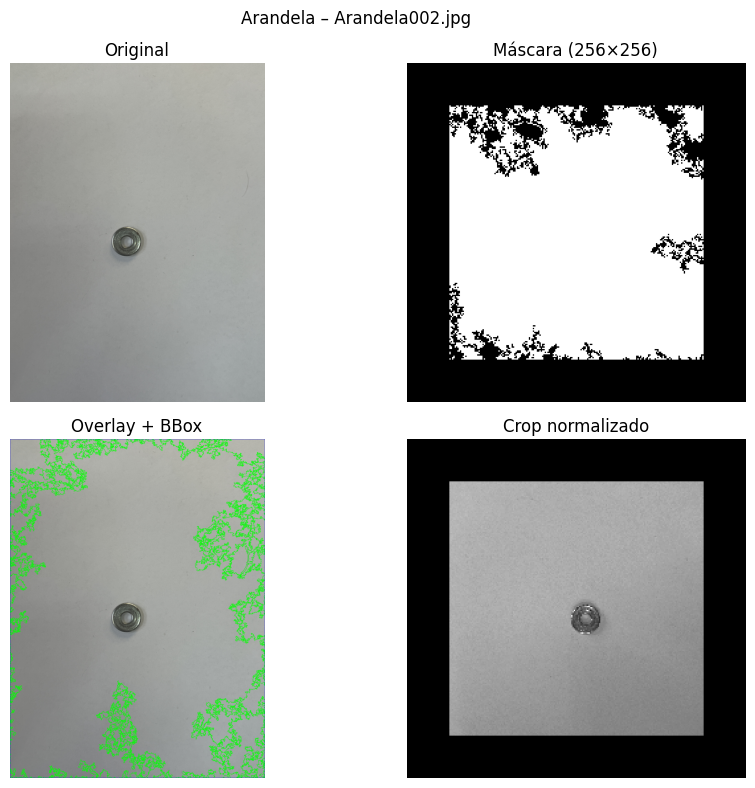

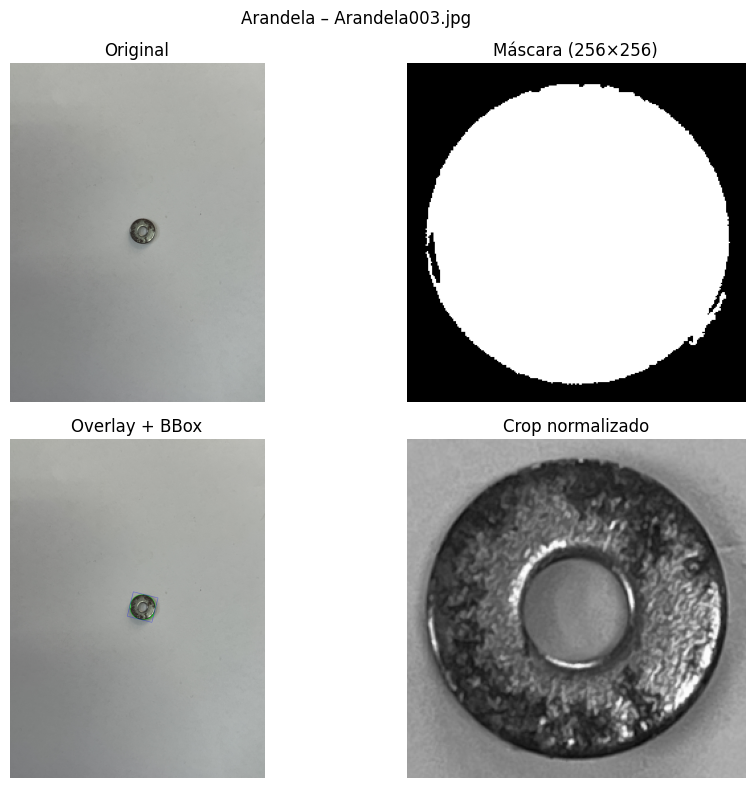

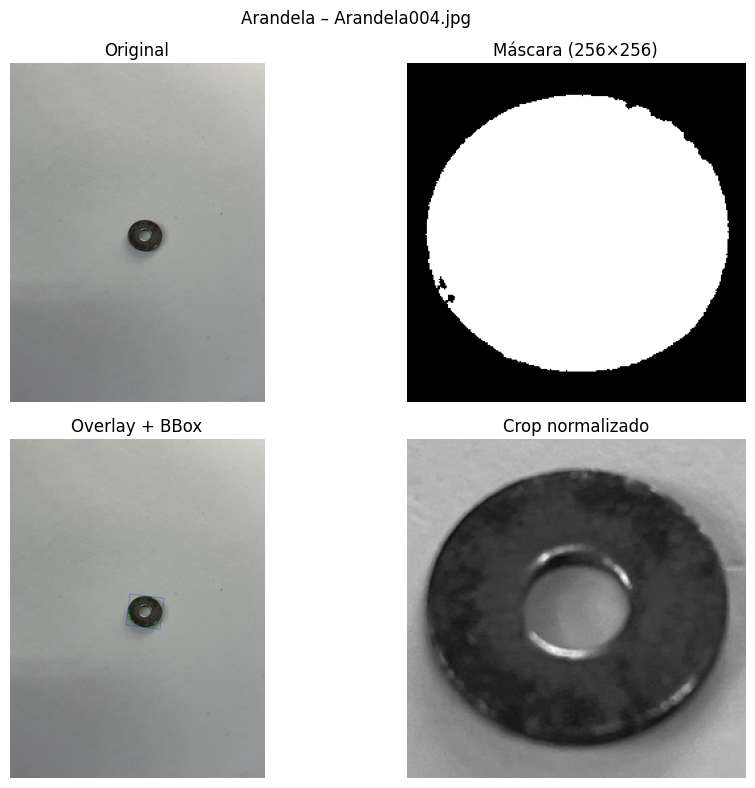

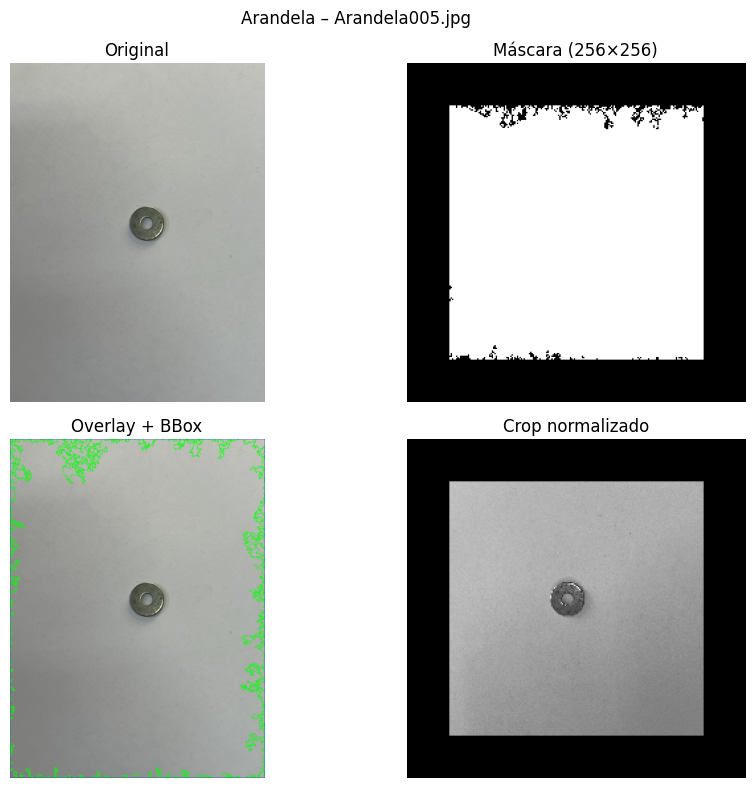

------------------------------------------------------------


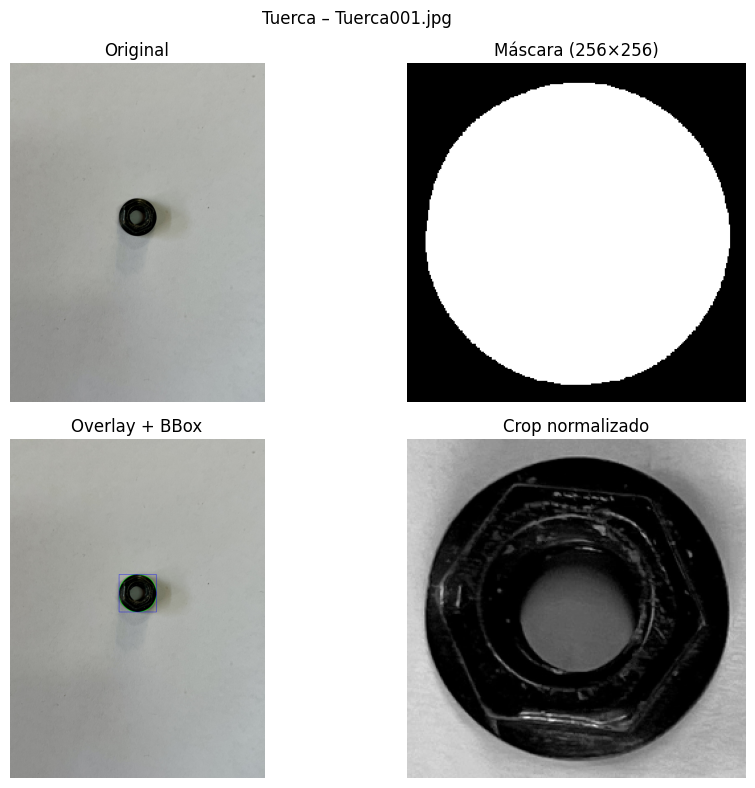

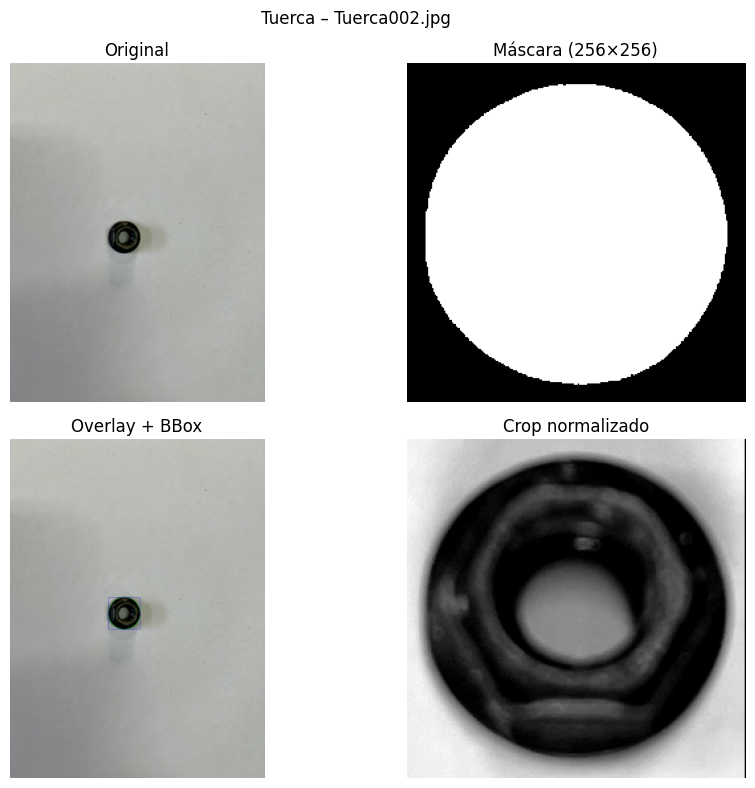

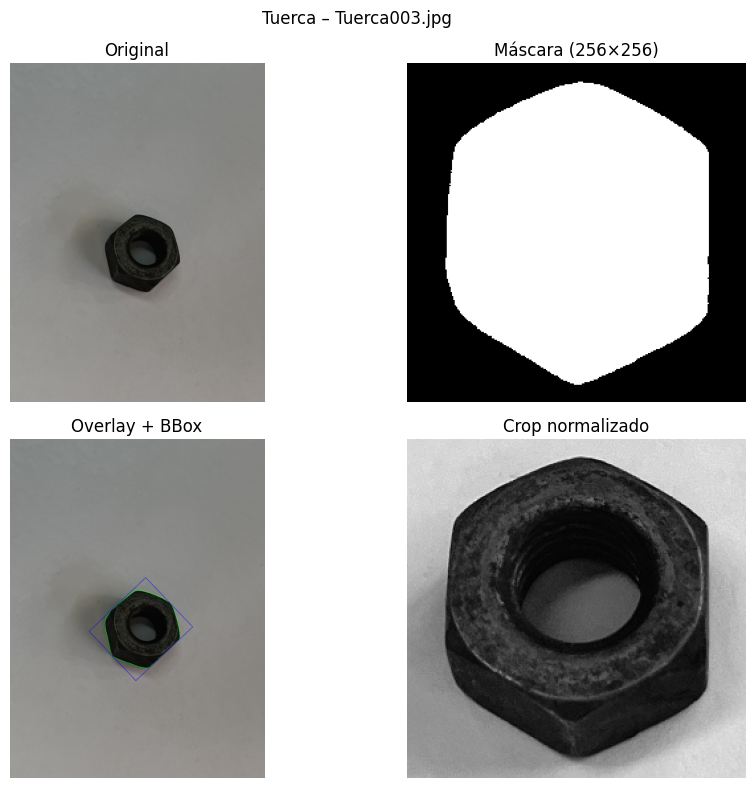

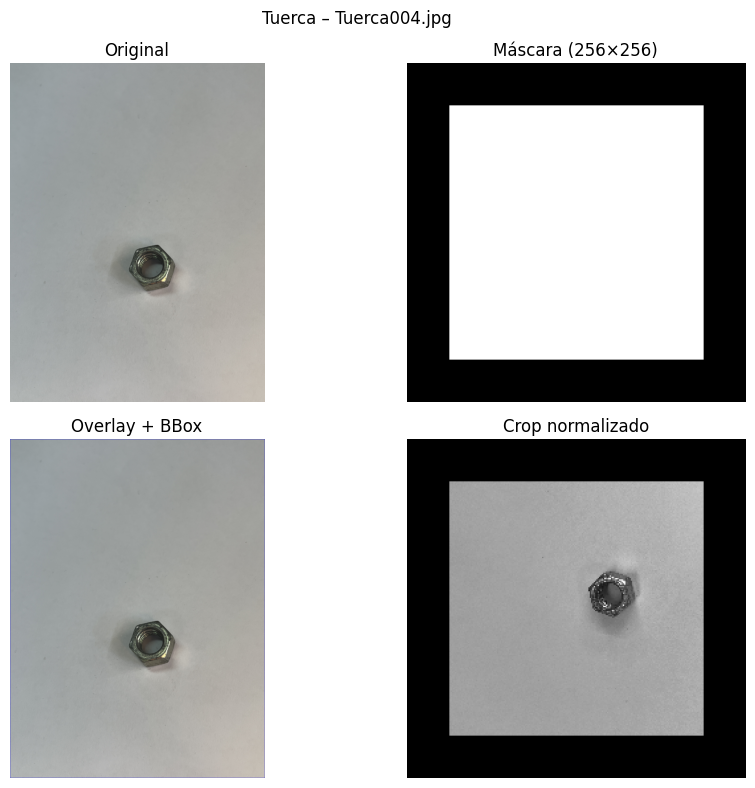

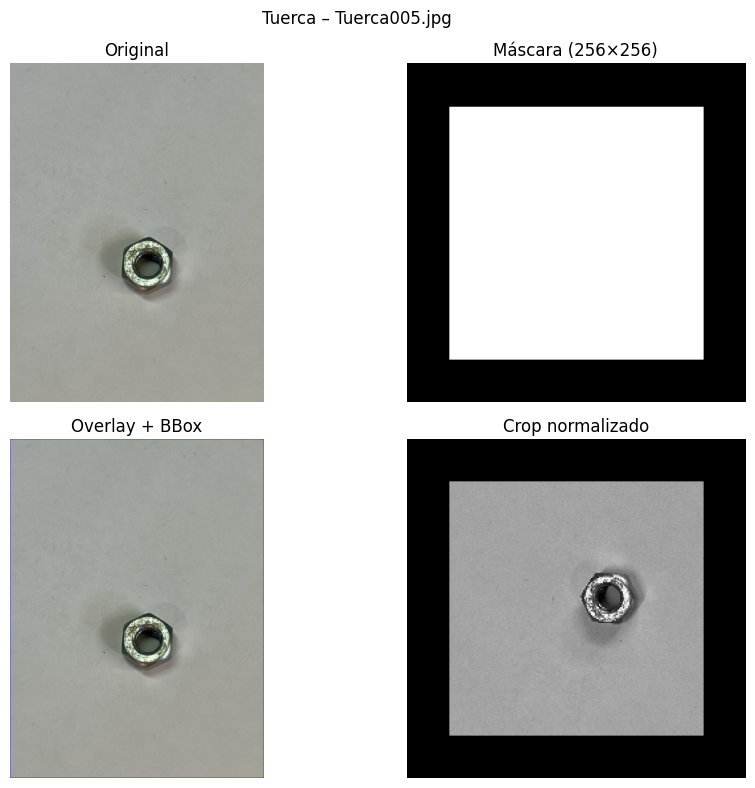

------------------------------------------------------------


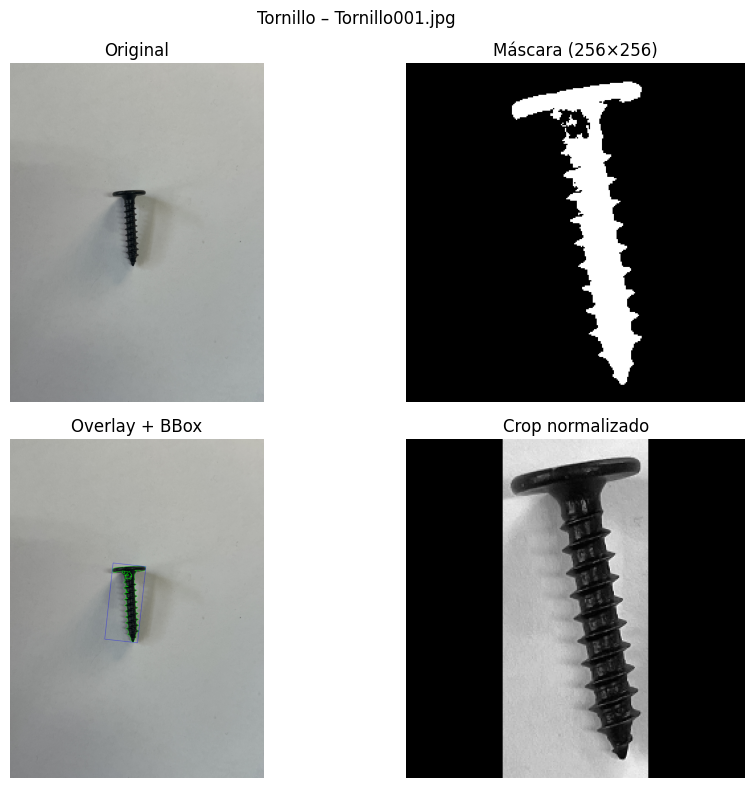

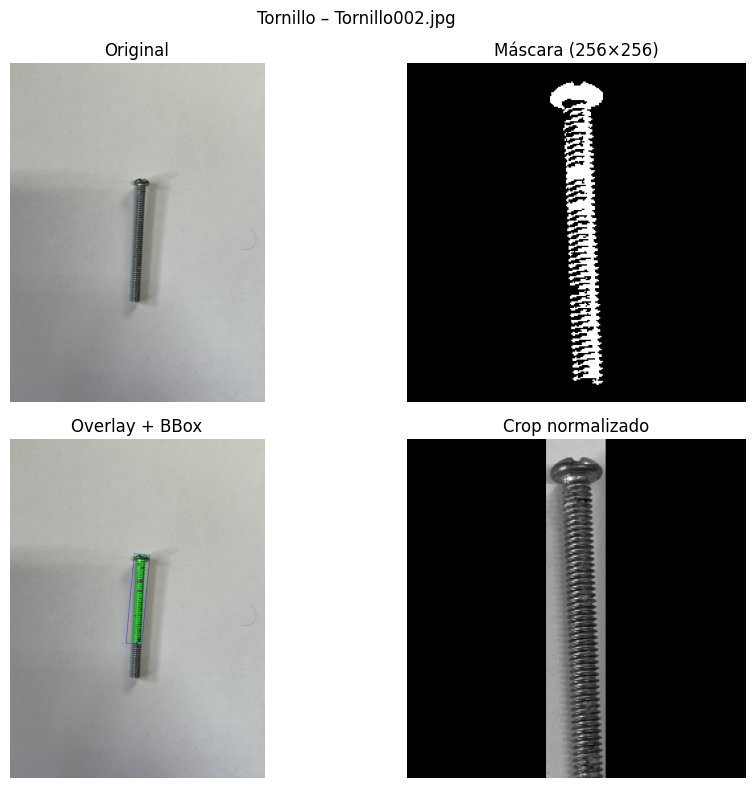

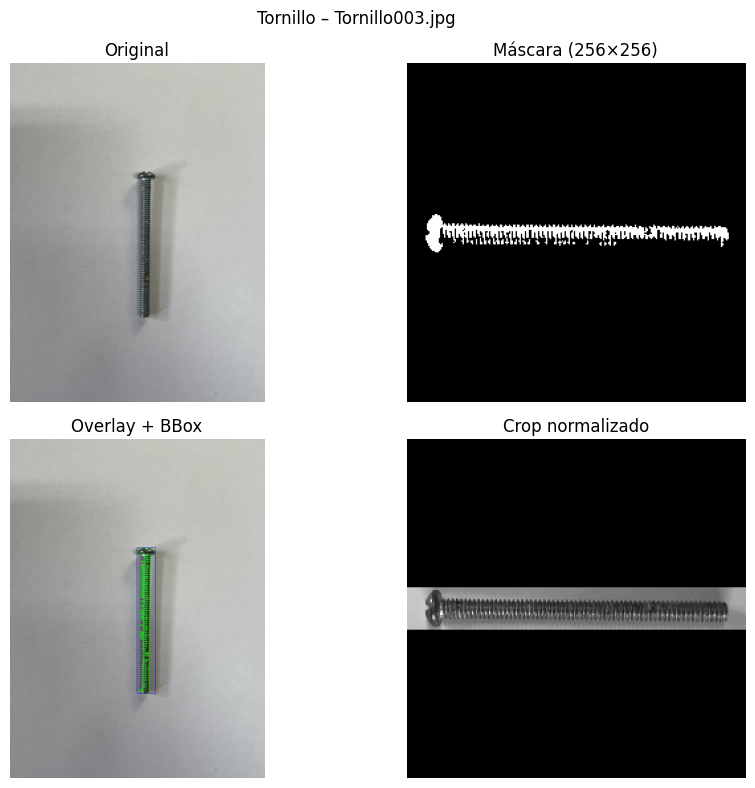

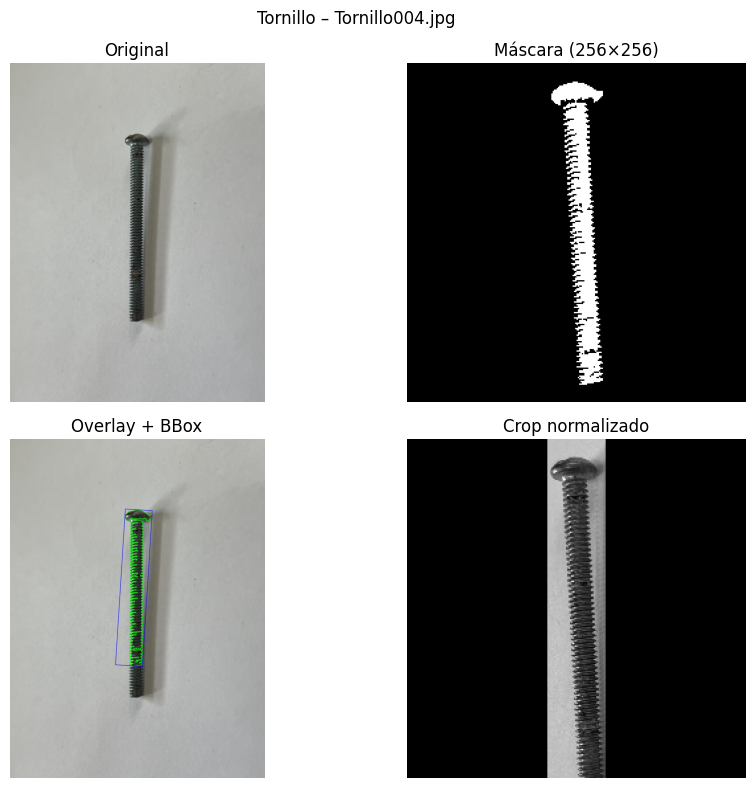

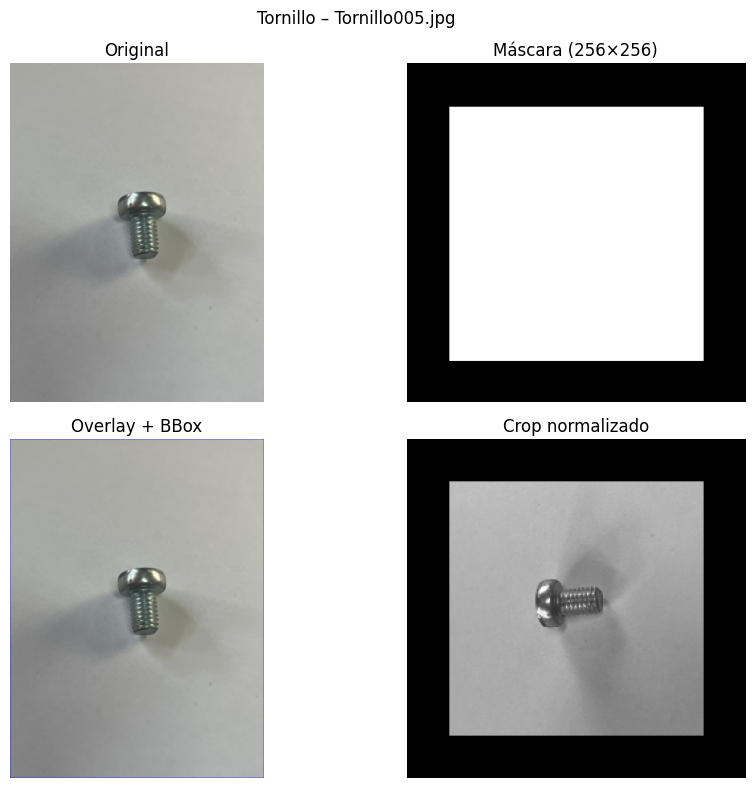

------------------------------------------------------------


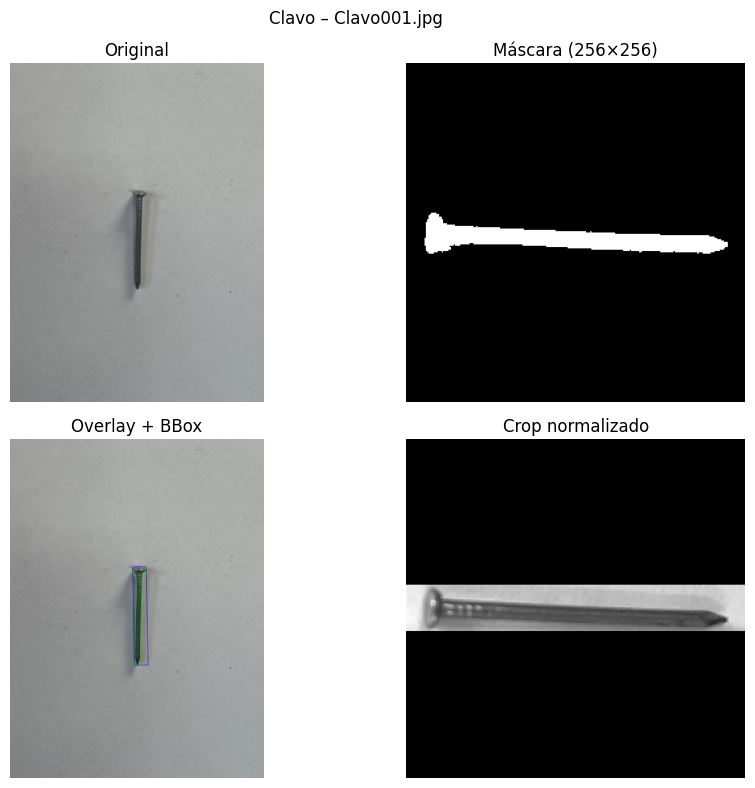

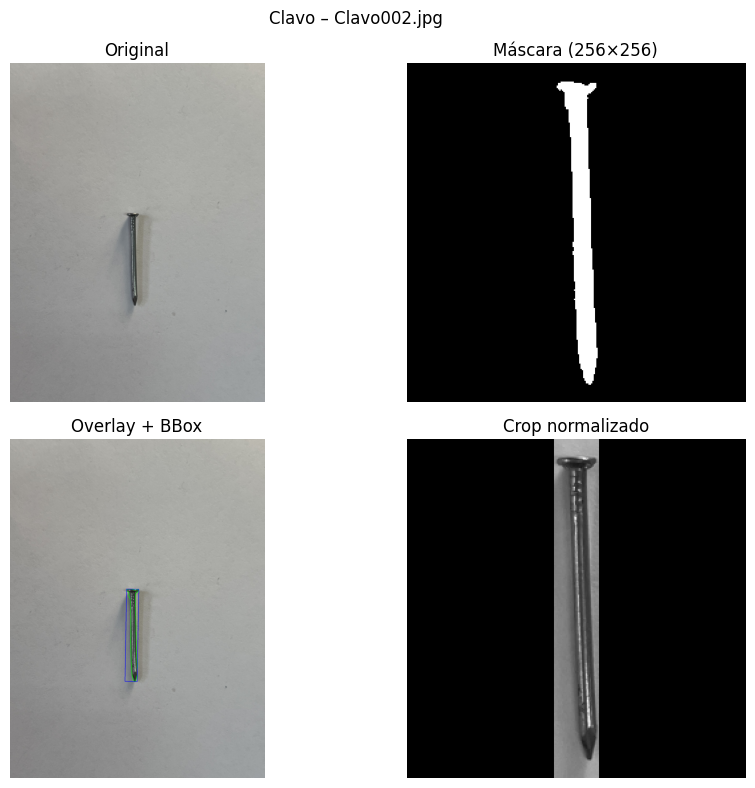

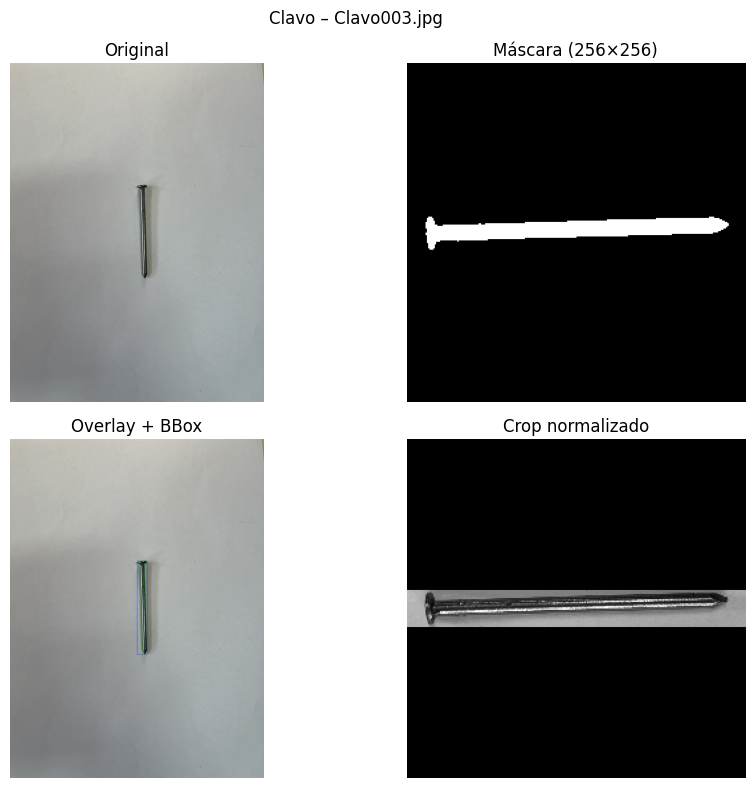

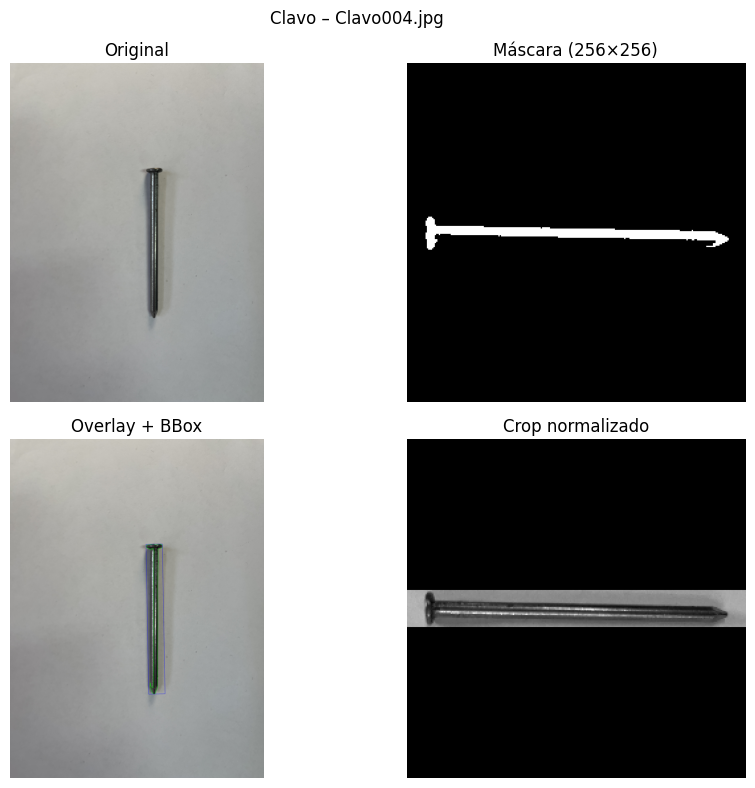

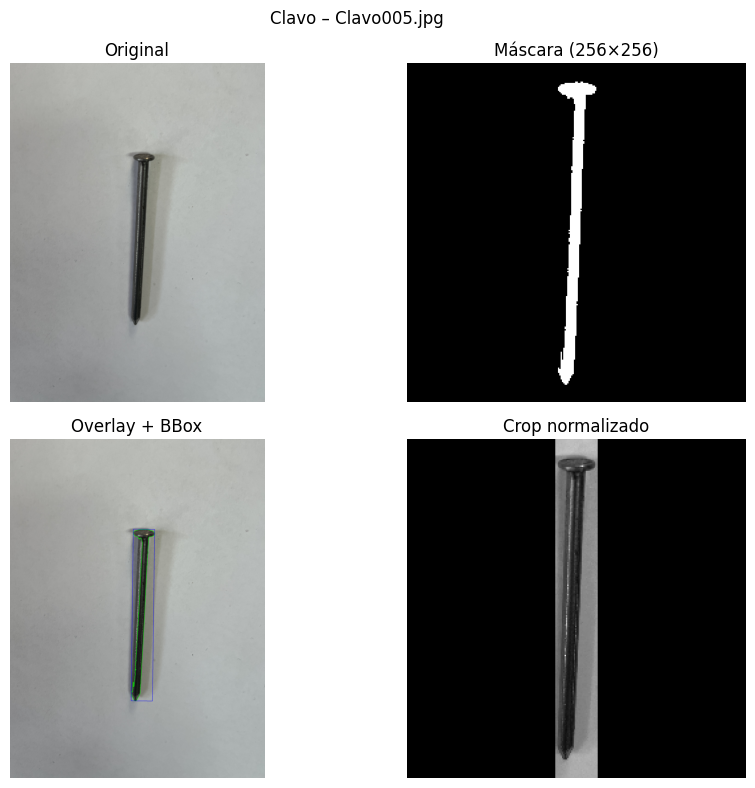

------------------------------------------------------------


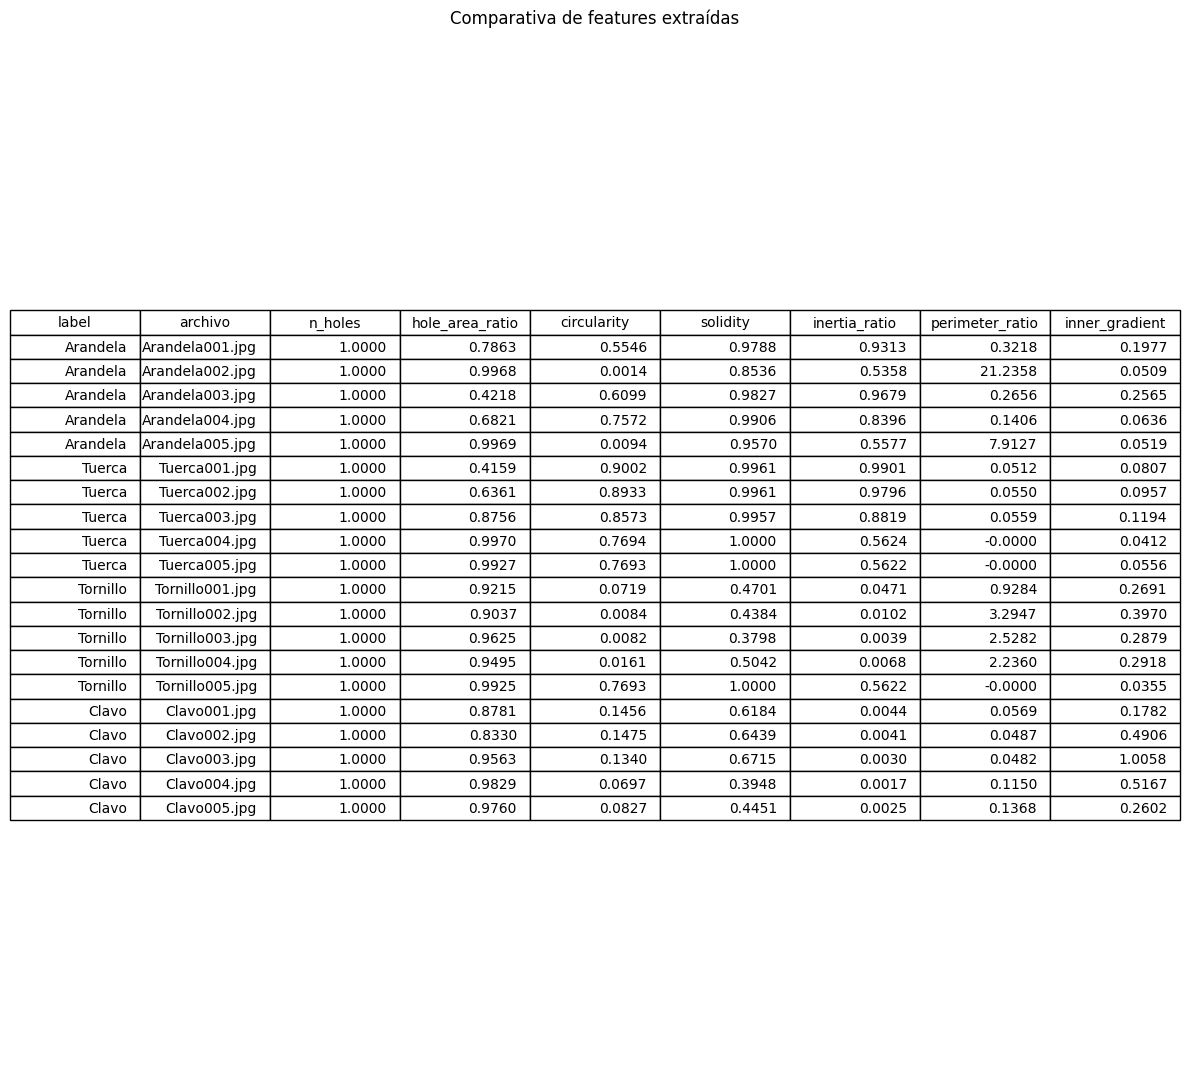

In [ ]:
from __future__ import annotations

from pathlib import Path
from typing import Optional

import numpy as np
import cv2
import matplotlib.pyplot as plt

from Code.types import PROJECT_ROOT
from Code.adapters import Repo
from Code.image.ImgPreproc import ImgPreproc, ImgPreprocCfg
from Code.image.ImgFeat import ImgFeat

repo = Repo(PROJECT_ROOT)
repo.ensure_layout()

pre_cfg = ImgPreprocCfg()
pre = ImgPreproc(pre_cfg)
feat_extractor = ImgFeat(mode="7D", use_meta=True)
feature_names = feat_extractor.feature_names(feat_extractor.mode)
np.set_printoptions(precision=4, suppress=True)

def load_sample(label: Optional[str] = None, dataset: str = "1", index: int = 0):
    images = repo.list_images(number=dataset, labels=[label] if label else None)
    if not images:
        raise FileNotFoundError(f"No se encontraron imágenes para label={label!r} en dataset {dataset}.")
    if index >= len(images):
        index %= len(images)
    path = images[index]
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"No pude leer {path}")
    return path, img

def visualize_preproc(img_bgr, pre_out, title: str = ""):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    axs[0, 0].set_title('Original')
    axs[0, 0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Máscara (256×256)')
    axs[0, 1].imshow(pre_out.mask, cmap='gray')
    axs[0, 1].axis('off')

    overlay = img_bgr.copy()
    if pre_out.meta is not None and pre_out.meta.contour is not None:
        contour = pre_out.meta.contour.astype(np.int32)
        cv2.drawContours(overlay, [contour], -1, (0, 255, 0), 2)
        box = cv2.boxPoints(pre_out.meta.rect).astype(np.int32)
        cv2.polylines(overlay, [box], True, (255, 0, 0), 2)
    axs[1, 0].set_title('Overlay + BBox')
    axs[1, 0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Crop normalizado')
    axs[1, 1].imshow(pre_out.img, cmap='gray', vmin=0.0, vmax=1.0)
    axs[1, 1].axis('off')

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    return fig

def format_features(names, vec):
    return ''.join(f'{name:>16}: {float(val):.4f}' for name, val in zip(names, vec))

# ---------------------------------------------------------------------- #
# Ejecución de ejemplo
# ---------------------------------------------------------------------- #

labels = ['Arandela', 'Tuerca', 'Tornillo', 'Clavo']
table_rows = []
cantidad_imagenes = 5

for label in labels:
    for i in range(cantidad_imagenes):
        path, img = load_sample(label, index=i)
        pre_out = pre.process(img)
        vec, names, debug = feat_extractor.extract(pre_out.img, pre_out.mask, pre_out.meta)

    # print(f'=== {label} | {path.name} ===')
    # print(format_features(names, vec))
    # print()

        visualize_preproc(img, pre_out, title=f'{label} – {path.name}')
        plt.show()

        table_rows.append((label, path.name, vec.copy()))
    print("-" * 80)
    # Ejemplo de acceso a valores de depuración
    # print('area:', debug['area'], 'holes:', debug['n_holes'])
    # print('-' * 60)

if table_rows:
    column_labels = ['label', 'archivo'] + feature_names
    cell_text = []
    for lbl, fname, vec_vals in table_rows:
        cell_text.append([lbl, fname] + [f"{float(v):.4f}" for v in vec_vals])

    fig, ax = plt.subplots(figsize=(12, 1.0 + 0.5 * len(cell_text)))
    ax.axis('off')
    table = ax.table(cellText=cell_text, colLabels=column_labels, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.0, 1.2)
    ax.set_title('Comparativa de features extraídas', pad=20)
    plt.tight_layout()
    plt.show()
